# Gamut correction

In this tutorial, we will introduce the concepts of gamut corrections - i.e. how to adjust a set of capture values to neatly fit within the gamut of a stimulation system.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

import dreye

Create hypothetical photoreceptor types and light sources

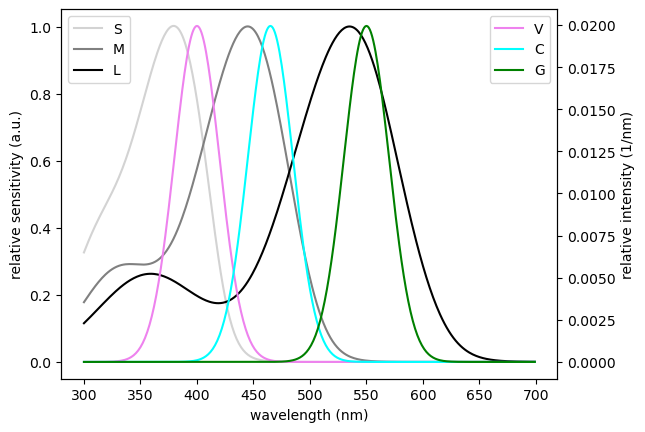

In [2]:
filters_colors = ['lightgray', 'gray', 'black']
sources_colors = ['violet', 'cyan', 'green']

# wavelength range
wls = np.arange(300, 700, 1)
# peaks of the sensitivities
peaks = np.array([380, 445, 535])
# opsin template
# an empty axis is added to the peaks so that the array object has dimension (opsin_type x wavelengths)
filters = dreye.govardovskii2000_template(wls, peaks[:, None])

led_peaks = np.array([400, 465, 550])
sources = norm.pdf(wls, loc=led_peaks[:, None], scale=20)
sources = sources / dreye.integral(sources, wls, axis=-1, keepdims=True)

est = dreye.ReceptorEstimator(
    # filters array
    filters, 
    ### ADDING FILTER UNCERTAINTY
    ### In this case it scales with the value of the filter function (heteroscedastic)
    filters_uncertainty=filters * 0.1,
    # wavelength array
    domain=wls, 
    # labels for each photoreceptor type (optional)
    labels=['S', 'M', 'L'], 
    # LED array, optional
    sources=sources, 
    # lower bound of each LED, optional
    lb=np.zeros(3), 
    # upper bound for each LED, optional - if None, then the upper bound is infinity
    ub=np.ones(3) * 0.1, 
    # labels for sources, optional
    sources_labels=['V', 'C', 'G'], 
    baseline=1e-3
)

ax1 = est.filter_plot(colors=filters_colors)
ax2 = plt.twinx(ax1)
est.sources_plot(colors=sources_colors, ax=ax2)

ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('relative sensitivity (a.u.)')
ax2.set_ylabel('relative intensity (1/nm)')

ax1.legend(loc=2)
ax2.legend(loc=1)

Load hyperspectral images and interpolate to wavelength points defined above:

In [3]:
image = np.load(os.path.join('data', 'flower_image.npy'))
image_wls = np.load(os.path.join('data', 'wls_image.npy'))
# convert hyperspectral image in units of W/m2 to photonflux units (uE)
image = dreye.irr2flux(image, image_wls, prefix='micro')
print(image.shape, image_wls.shape)

im = interp1d(image_wls, image, axis=-1, bounds_error=False, fill_value=0)(wls)
print(im.shape)
im_shape = im.shape[:2]
# reshape to 2D
im = im.reshape(-1, wls.size)
print(im.shape)

(100, 100, 270) (270,)
(100, 100, 400)
(10000, 400)


The photoreceptors will be adapted to the mean spectrum of the image

In [4]:
est.register_background_adaptation(im.mean(0))
print(est.K)

[0.13112469 0.10144013 0.03367139]


Calculate the relative capture for all points in the image

In [5]:
B = est.relative_capture(im)

Plot capture image

[0 0 0] [255 255 255]


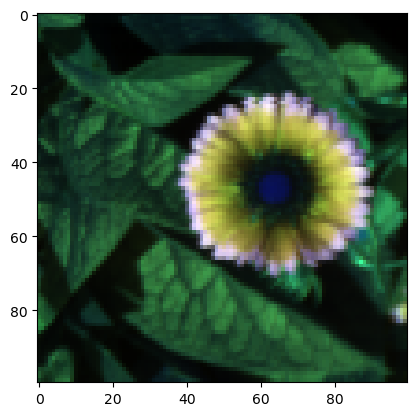

In [6]:
# rescale value for better contrast, and convert to uint8

def scale_reformat_image(B, im_shape):
    capture_image = (B - np.min(B, 0)) / (np.max(B, 0) - np.min(B, 0))
    capture_image = capture_image.reshape(*im_shape, -1)
    capture_image = (capture_image * 255).astype(np.uint8)
    return capture_image

capture_image = scale_reformat_image(B, im_shape)
print(capture_image.min((0, 1)), capture_image.max((0, 1)))

plt.imshow(capture_image.reshape(*im_shape, -1))

Let's plot a pairwise gamut plot to see if points are within the gamut

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='S', ylabel='M'>, <Axes: xlabel='S', ylabel='L'>,
        <Axes: xlabel='M', ylabel='L'>], dtype=object))

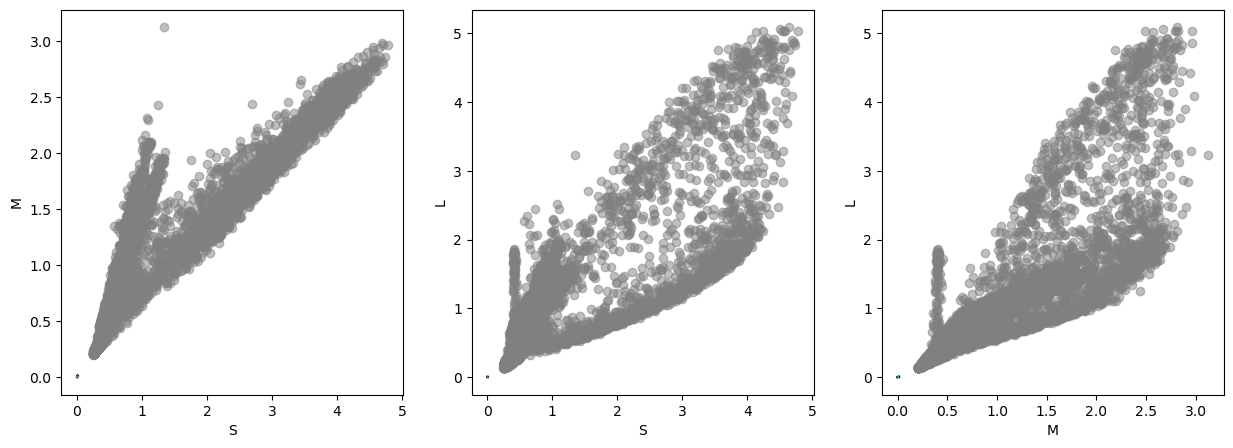

In [7]:
est.gamut_plot(B, colors=sources_colors, ncols=3, fig_kws={'figsize': (15, 5)}, c='gray', alpha=0.5)

As can be seen in these plots, all points are highly outside of the gamut of the system because the intensity range of the system is limited.

Let's first try to scale the overall intensity of the image (i.e the L1 norm) using the `gamut_l1_scaling` method:

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='S', ylabel='M'>, <Axes: xlabel='S', ylabel='L'>,
        <Axes: xlabel='M', ylabel='L'>], dtype=object))

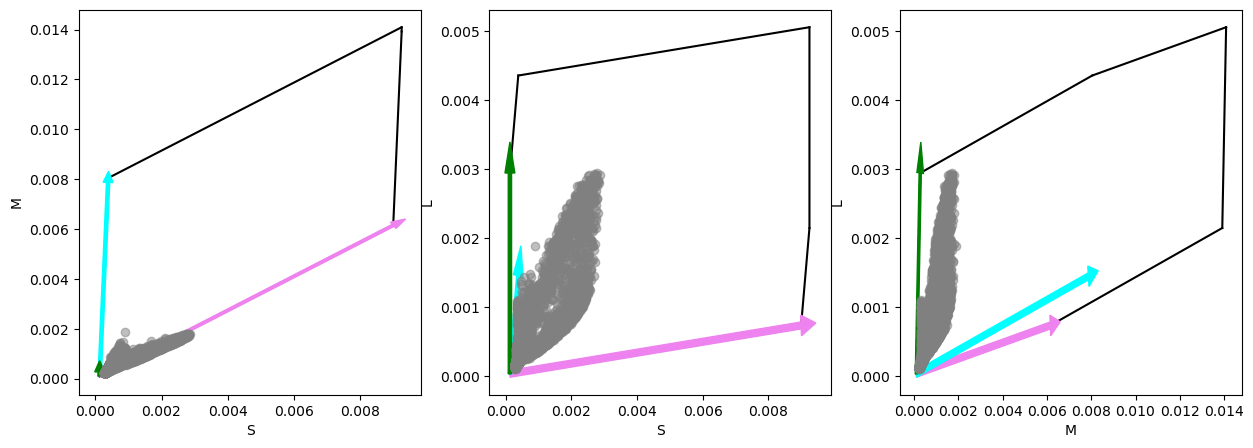

In [8]:
Bscaled = est.gamut_l1_scaling(B)

est.gamut_plot(Bscaled, colors=sources_colors, ncols=3, fig_kws={'figsize': (15, 5)}, c='gray', alpha=0.5, vectors_kws={'width': 0.0001})

We can now see that the intensity range of the image is more properly scaled for the image, but various values still remain outside of the gamut. For this we can try to scale the angles in the L1-normalized simplex (chromaticity diagram) to adjust the animal's ``saturation'' value for each pixel. To do this we have the `gamut_dist_scaling` method:

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='S', ylabel='M'>, <Axes: xlabel='S', ylabel='L'>,
        <Axes: xlabel='M', ylabel='L'>], dtype=object))

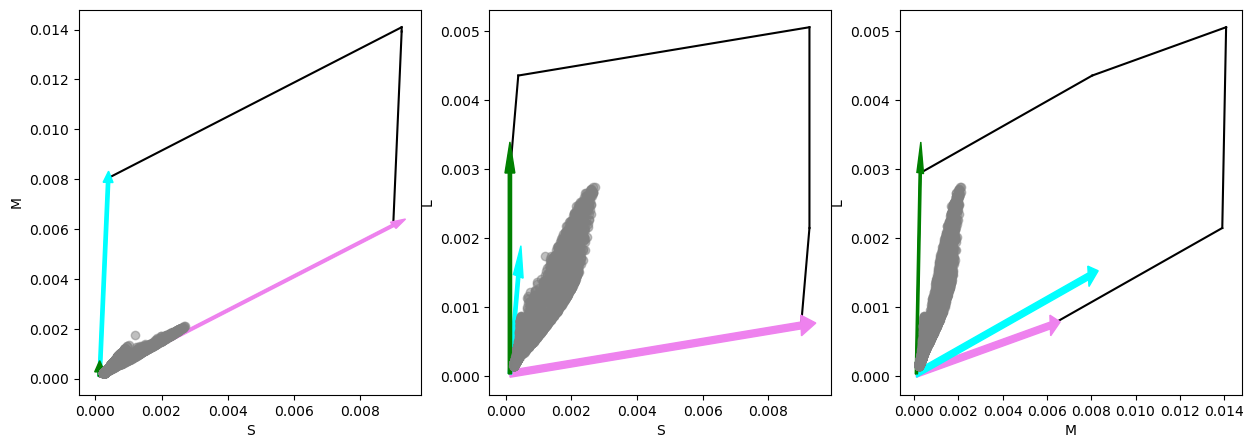

In [9]:
Bscaled2 = est.gamut_dist_scaling(Bscaled)

est.gamut_plot(Bscaled2, colors=sources_colors, ncols=3, fig_kws={'figsize': (15, 5)}, c='gray', alpha=0.5, vectors_kws={'width': 0.0001})

This method does not guarantee that all points will be within the hull, but aims to get as many points as possible within the hull. The method can also give weird results if a lot of points are outside the hull, and the projection into the hull would still leave most points outside the hull. 

0.0
0.8647
0.9998


Text(0.5, 1.0, 'saturation scaled targets')

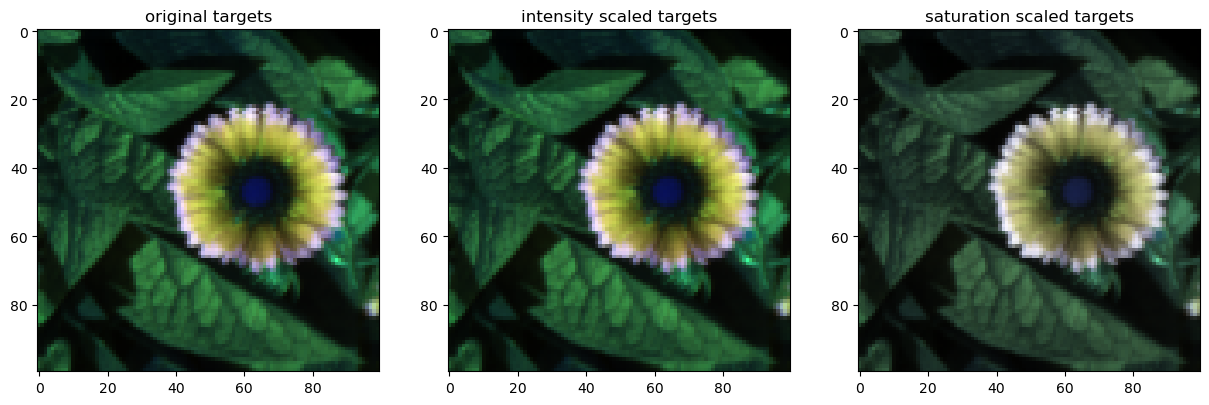

In [10]:
B_in = est.in_gamut(B)
Bscaled_in = est.in_gamut(Bscaled)
Bscaled2_in = est.in_gamut(Bscaled2)

# fraction within the hull
print(np.mean(B_in))
print(np.mean(Bscaled_in))
print(np.mean(Bscaled2_in))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

ax1.imshow(scale_reformat_image(B, im_shape).reshape(*im_shape, -1))
ax2.imshow(scale_reformat_image(Bscaled, im_shape).reshape(*im_shape, -1))
ax3.imshow(scale_reformat_image(Bscaled2, im_shape).reshape(*im_shape, -1))

ax1.set_title('original targets')
ax2.set_title('intensity scaled targets')
ax3.set_title('saturation scaled targets')


For the gamut corrected images, we can fit our targets as in the introduction:

In [11]:
# we will ignore the fitted intensities here since we care more about how much the image gets
# burned after fitting
# We will batch across pixels (i.e. samples), so that the fitting procedure is faster
_, Bscaled_hat = est.fit(Bscaled, batch_size=100)
_, Bscaled2_hat = est.fit(Bscaled2, batch_size=100)

Text(0.5, 1.0, 'fitted saturation scaled targets')

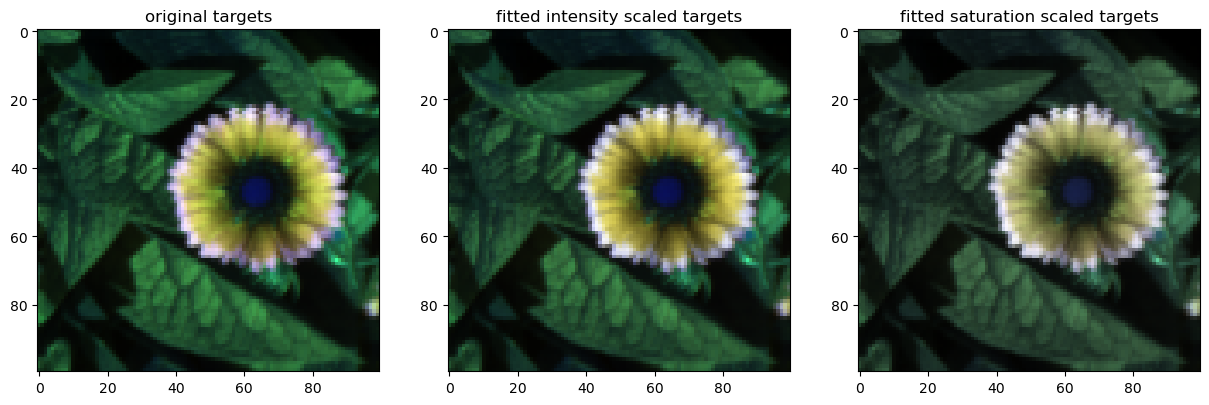

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

ax1.imshow(scale_reformat_image(B, im_shape).reshape(*im_shape, -1))
ax2.imshow(scale_reformat_image(Bscaled_hat, im_shape).reshape(*im_shape, -1))
ax3.imshow(scale_reformat_image(Bscaled2_hat, im_shape).reshape(*im_shape, -1))

ax1.set_title('original targets')
ax2.set_title('fitted intensity scaled targets')
ax3.set_title('fitted saturation scaled targets')

For this case, it appears that intensity scaling alone is probably sufficient and that saturation scaling changes the image color too much (as the stimulation system does not have a wide gamut for S vs. L/M - see previous gamut plots)

## Scaling intensity and saturation simultaneously

We have also implemented an algorithm that scales saturation and intensity simultaneously, that allows us to fine-tune the tradeoff between the two. To do this, we need to use the method `fit_adaptive`:

[0.00066015 0.00048893]


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='S', ylabel='M'>, <Axes: xlabel='S', ylabel='L'>,
        <Axes: xlabel='M', ylabel='L'>], dtype=object))

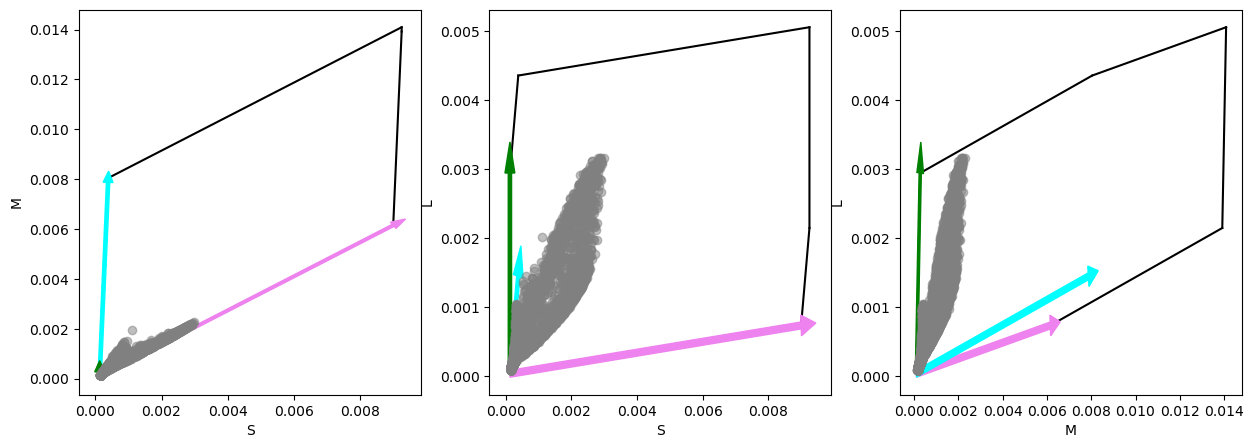

In [13]:
_, scales, Bscaled_fit = est.fit_adaptive(
    B, 
    # maximum difference between scaled intensity and achieved intensity for single sample 
    delta_norm1=1e-5,
    # maximum difference between scaled chromatic value and achieved chromatic value (i.e. l1-normalized sample) for single sample
    delta_radius=1e-4,  # we want to preserve the chromatic values well
    # the two parameters above are highly dependent on the range of values of B
    # here the objectives details are set
    adaptive_objective='max',  # try to obtain the maximum relative intensity and relative chromatic values possible
    scale_w=np.array([0.001, 10]),  # trade-off between intensity and chromatic value for max objective
)

# how intensity and saturation are scaled
print(scales)

est.gamut_plot(Bscaled_fit, colors=sources_colors, ncols=3, fig_kws={'figsize': (15, 5)}, c='gray', alpha=0.5, vectors_kws={'width': 0.0001})

Text(0.5, 1.0, 'fitting of intensity and scale')

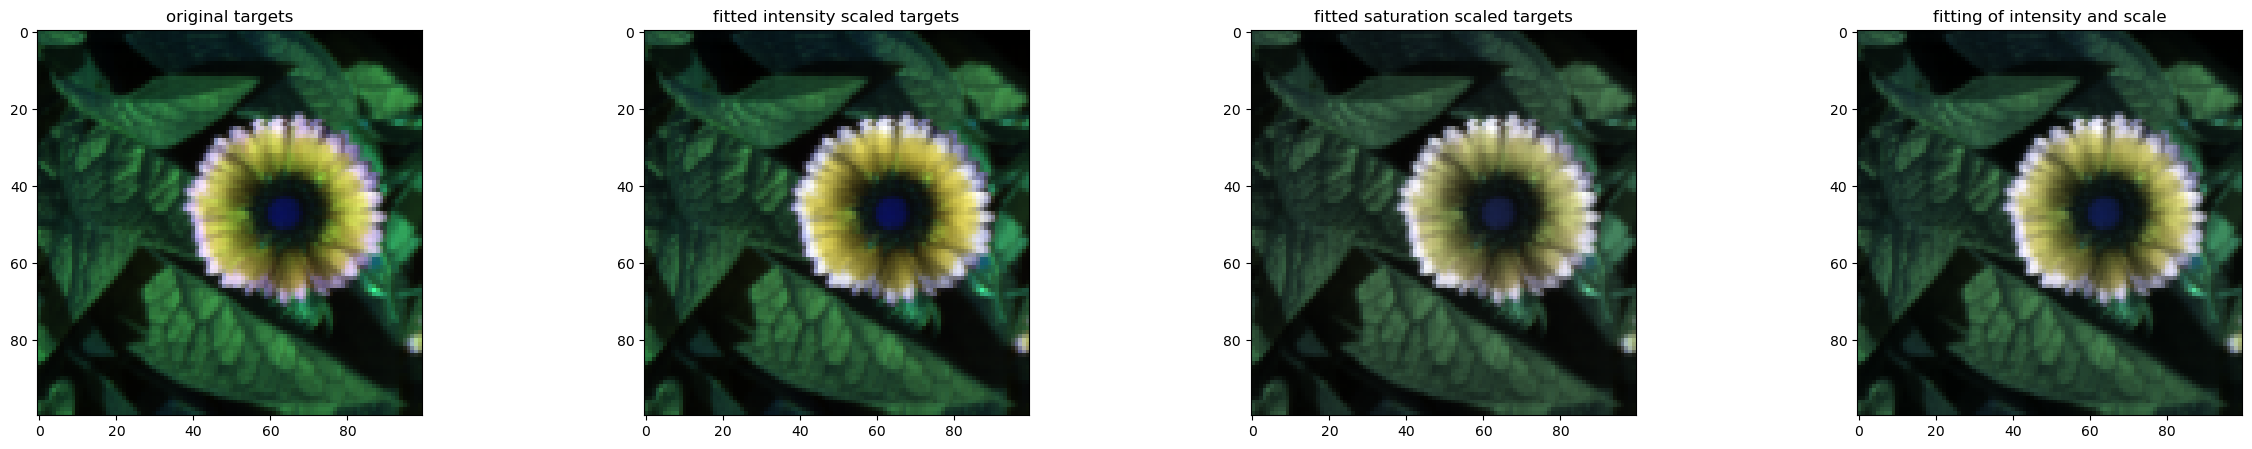

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(30, 5))

ax1.imshow(scale_reformat_image(B, im_shape).reshape(*im_shape, -1))
ax2.imshow(scale_reformat_image(Bscaled_hat, im_shape).reshape(*im_shape, -1))
ax3.imshow(scale_reformat_image(Bscaled2_hat, im_shape).reshape(*im_shape, -1))
ax4.imshow(scale_reformat_image(Bscaled_fit, im_shape).reshape(*im_shape, -1))

ax1.set_title('original targets')
ax2.set_title('fitted intensity scaled targets')
ax3.set_title('fitted saturation scaled targets')
ax4.set_title('fitting of intensity and scale')

More details on the methods can be found in the API reference.

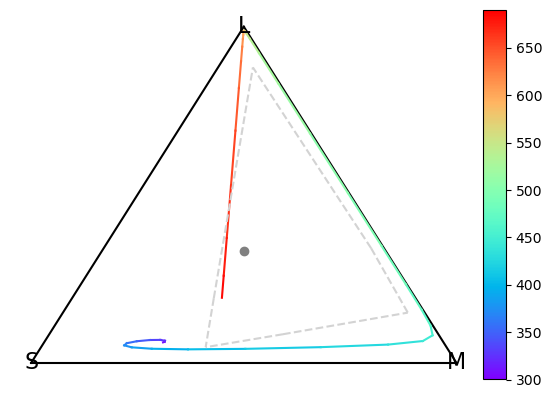

In [16]:
est.simplex_plot()
plt.show()